# LSTM trial 1

Architecture adopted from https://cnvrg.io/pytorch-lstm/

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from Data_loader import get_WL_data, get_prcp_data

### Load data

In [2]:
WL, _, station_name_to_id, _ = get_WL_data(r'C:\Users\henri\Documents\Universität\Masterthesis\DMI_data\Data_WL')
prcp=get_prcp_data(r'C:\Users\henri\Documents\Universität\Masterthesis\DMI_data\SVK', r'C:\Users\henri\Documents\Universität\Masterthesis\DMI_data\DMI_Climate_Data_prcp', join=True)

### Preprocessing

In [3]:
#remove outliers from WL data with z-score in order to train model with "good" time-series
#calculate z-score
zscore=(WL-WL.mean())/WL.std()
#threshhold for detecting outliers
threshold=3
WL_wo_anom= WL 
for col in WL.columns:
    WL_wo_anom[col][np.abs(zscore[col])>threshold]=np.nan

Get data for test station

In [4]:
test_station='ns Uldumkær'
test_id=station_name_to_id.get(test_station)
test_prcp='05225'
X_WL=WL_wo_anom[[test_id]]
X_prcp=prcp[[test_prcp]]

In [5]:
#make sure that only period in which sensor data is available is used
X_WL=X_WL[(X_WL.index>X_WL.first_valid_index())&(X_WL.index<X_WL.last_valid_index())]
X_prcp=X_prcp[(X_prcp.index>X_prcp.first_valid_index())&(X_prcp.index<X_prcp.last_valid_index())] 

In [6]:
#merge precipitation and WL data, select overlapping timeperiod
X=pd.concat([X_WL, X_prcp], axis=1).loc[X_WL.index.intersection(X_prcp.index)]

#### Split in Train and test data
There is data available from '2011-11-09 11:00:00' to '2023-08-08 23:00:00' so in total 10 complete years of data. <br> 
In order to have complete seasonality in the data it makes sense to keep complete years in both the test and the train dataframes.
<br>
For the beginning I arbitrarily split the data in 7  years for training, 2 years for test and 1 year for validation.

In [7]:
#note: pd slicing is inlcusive
X_train=X['2011-01-01':'2018-12-31']
X_test=X['2019-01-01':'2021-12-31']
X_val=X['2022-01-01':'2022-12-31']

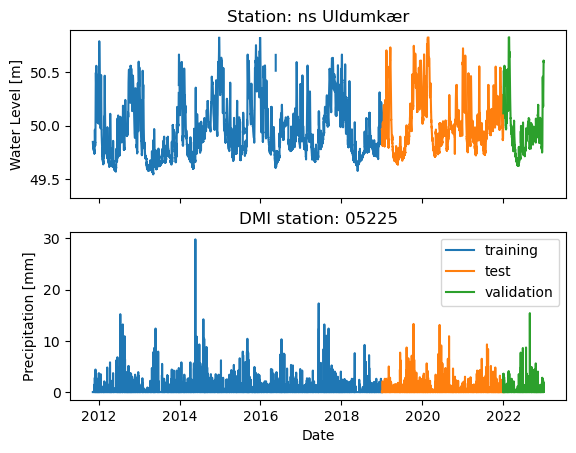

In [32]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(X_train[[test_id]], label='training')
ax[0].plot(X_test[[test_id]], label='test')
ax[0].plot(X_val[[test_id]], label='validation')
ax[0].set_ylabel('Water Level [m]')
ax[0].set_title(f'Station: {test_station}')
#ax[0].axvspan(1,1, color='green')
ax[1].plot(X_train[test_prcp], label='training')
ax[1].plot(X_test[test_prcp], label='test')
ax[1].plot(X_val[test_prcp], label='validation')
ax[1].set_ylabel('Precipitation [mm]')
ax[1].set_xlabel('Date')
ax[1].set_title(f'DMI station: {test_prcp}')
ax[1].legend()

#### Standardization, normalisation

In [9]:
#scale and normalise such that all data has a range between [0,1]
mm=MinMaxScaler()
X_train_mm=mm.fit_transform(X_train)
X_test_mm=mm.fit_transform(X_test)
X_val_mm=mm.fit_transform(X_val)

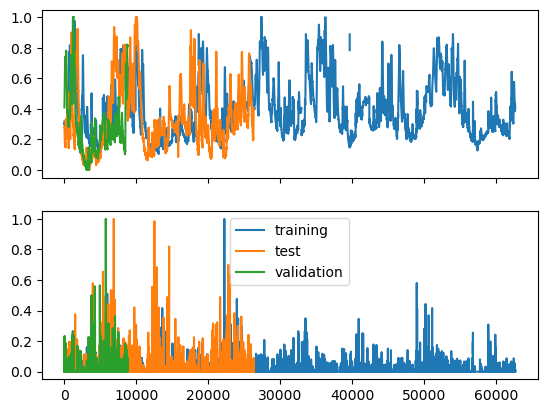

In [10]:
#Visualise results from scaler

fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(X_train_mm[:,0], label='training')
ax[0].plot(X_test_mm[:,0], label='test')
ax[0].plot(X_val_mm[:,0], label='validation')
#ax[0].axvspan(1,1, color='green')
ax[1].plot(X_train_mm[:,1], label='training')
ax[1].plot(X_test_mm[:,1], label='test')
ax[1].plot(X_val_mm[:,1], label='validation')

ax[1].legend()

### Data preparation for LSTM

#### Get Windowed data with Philipps code
Code creates batches of windowed data such that it can be used as an input in the LSTM.<br>
Input to window code must have format [time,...,features], that's already the format we get out of the scaler.

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [12]:
def _get_labelled_window(windowed_data, horizon: int):
    """Create labels for windowed dataset
    Input: [0, 1, 2, 3, 4, 5] and horizon=1
    Output: ([0, 1, 2, 3, 4], [5])

    Parameters
    ----------
    data : array
        time series to be labelled
    horizon : int
        the horizon to predict
    """
    return windowed_data[:, :-horizon], windowed_data[:, -horizon:]

In [13]:
def timeseries_dataset_from_array(data, window_size, horizon, stride=1, label_indices: list=None):
    # Adapted from https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
    # and https://www.mlq.ai/time-series-tensorflow-windows-horizons/
    """Creates windows and labels
    Input data must have format [time, ..., features], where ... can be e.g. lat and lon.
    Outputs have format [batch, time, ..., feature]. Number of features can vary depending on label_indices.

    Returns
    -------
    tuple(array, array)
        Windows and labels with shapes [batch, time, ..., feature]
    """
    # Create window of the specific size. Add horizon for to include labels.
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    # Create the timesteps. subtract window_size and horizon to get equal length windows and subtract 1 to account for
    # 0-indexing
    time_step = np.expand_dims(
        np.arange(data.shape[0] - (window_size + horizon - 1), step=stride), axis=0
    ).T

    # Create the window indexex
    window_indexes = window_step + time_step

    # Get the windows from the data in [batch, time, ..., features]
    windowed_data = data[window_indexes]

    # Split windows and labels
    windows, labels = _get_labelled_window(windowed_data, horizon)

    # Select only the labels we need
    if label_indices is not None:
        assert (
            type(label_indices) == list
        ), f"label_indices needs to be list[int], but is {type(label_indices)}"
        labels = labels[..., label_indices]

    return windows, labels

Dimensions of input + outputs:<br>

**input**<br>
input: [Time, F] <br>

**window output**<br>
features: [Time - S, S, F]<br>
labels: [Time - S, H, F] <br>

**data_loader output**<br>
input_data: [B, S, F]<br>
target_data: [B, H, F]<br>

with B=Batchsize, S=Window Size (=Nr of timesteps chosen as input), H=Horizon (nr. of timesteps model will predict), F=nr. of features

As a start, the model is only build on training data, using a 10 timesteps (window_size) to predict the following timestep (horizon).

In [14]:
window_size=10
horizon=1

In [15]:
#get input and targets in batches with 10 timesteps input and predict the next timestep t+1, prcp data is only important for input, therefore label
features, labels = timeseries_dataset_from_array(X_train_mm, window_size, horizon, label_indices=[0]) 

In [31]:
X_train_mm.shape #shape:(nr of timesteps, nr of inputs)

(62629, 2)

In [32]:
features.shape #shape should be: (nr of timesteps-window-size, window size, nr of features)

(62619, 10, 2)

In [34]:
labels.shape #shape should be: (nr of timesteps-window-size, horizon, nr of targets)

(62619, 1, 1)

In [16]:
dataset = torch.utils.data.TensorDataset(torch.tensor(features), torch.tensor(labels)) # insert into tensor dataset

In [17]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True) # insert dataset into data loader

In [199]:
input_data, target_data = next(iter(data_loader))

In [200]:
input_data.shape

torch.Size([10, 10, 2])

In [201]:
target_data.shape

torch.Size([10, 1, 1])

In [152]:
X_train_mm

array([[0.31837381, 0.        ],
       [0.31731785, 0.        ],
       [0.31731785, 0.        ],
       ...,
       [0.40390707, 0.        ],
       [0.4032031 , 0.        ],
       [0.40214713, 0.        ]])

### LSTM architecture

Definition of the LSTM model and forward pass of the LSTM.

In [18]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

Definition of hyperparameters

In [19]:
num_epochs = 10 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

Instantiate  the class LSTM1 object.

In [22]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, window_size) #our lstm class
lstm1.float()

LSTM1(
  (lstm): LSTM(2, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [23]:
print(lstm1)

LSTM1(
  (lstm): LSTM(2, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


Choose loss function and Optimizer

In [24]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [215]:
input_data[0,0,0]

tensor(0.3471, dtype=torch.float64)

Training of the model

In [28]:
for epoch in range(num_epochs):
    for input_data, target_data in data_loader:
      outputs = lstm1.forward(input_data.float()) #forward pass
      optimizer.zero_grad() #caluclate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs, target_data.float())

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

C:\Users\henri\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan
Epoch: 0, loss: nan


C:\Users\henri\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([9, 1, 1])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
